<a href="https://colab.research.google.com/github/sarahcodebyte/Hate-Speech-Detection-using-NLP/blob/main/Hate_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing dependencies**

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

# **Data Collection**

In [2]:
train = pd.read_csv('/content/train_E6oV3lV.csv')
test = pd.read_csv('/content/test_tweets_anuFYb8.csv')

In [3]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


# **Data Cleaning**

In [5]:
#combining the two datasets
combi = train.append(test, ignore_index=True)
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)

  return input_txt

#dropping twitter handles(@username)
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], '@[/w]*') 

In [6]:
#remove special characters, numbers, punctuations
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", ' ')

<ipython-input-6-de1033aa794c>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", ' ')


In [7]:
#remove short word
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
combi['tidy_tweet'].head()

0    user when father dysfunctional selfish drags k...
1    user user thanks #lyft credit cause they offer...
2                                  bihday your majesty
3                           #model love take with time
4                       factsguide society #motivation
Name: tidy_tweet, dtype: object

# **NLP Pipeline**

In [8]:
#tokenization
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [user, when, father, dysfunctional, selfish, d...
1    [user, user, thanks, #lyft, credit, cause, the...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [9]:
#Stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet.head()

0    [user, when, father, dysfunct, selfish, drag, ...
1    [user, user, thank, #lyft, credit, caus, they,...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [10]:
#stitch
for i in range(len(tokenized_tweet)):
  tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tidy_tweet'] = tokenized_tweet  


# **Data Visualisation Part-1**

Displaying all the root words occuring commonly

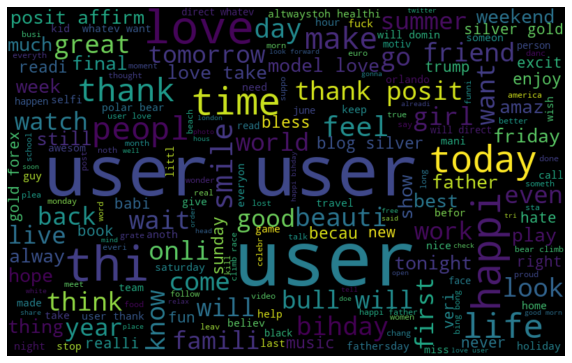

In [12]:
all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

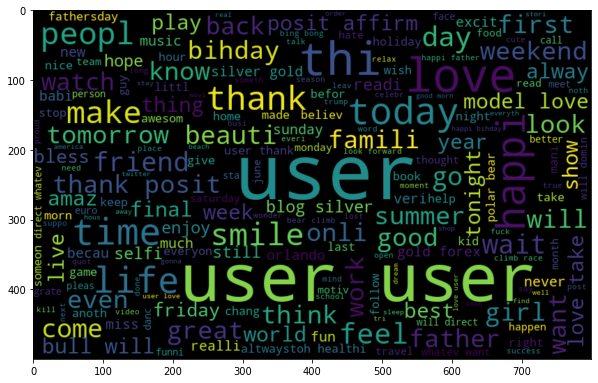

In [14]:
#non-hateful words in tweets
normal_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 10, max_font_size = 110).generate(normal_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('on')
plt.show()

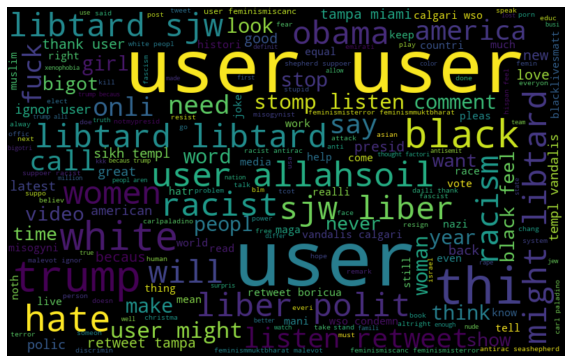

In [16]:
#hateful words in tweets
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])
wordcloud = WordCloud(width = 800, height = 500, random_state = 21, max_font_size = 110).generate(negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# **Data Processing Part-1**

In [21]:
#function to collect hastags
def hashtag_extract(x):
  hashtags = []
  #loop over the words in the tweet
  for i in x:
    ht = re.findall(r"#(\w+)", i)
    hashtags.append(ht)

  return hashtags  

In [22]:
#hashtags with non-hateful words
HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])

#hashtags with hateful words
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])

#unnesting list
HT_regular = sum(HT_regular, [])
HT_negative = sum(HT_negative, [])


# **Data Visualisation Part-2**

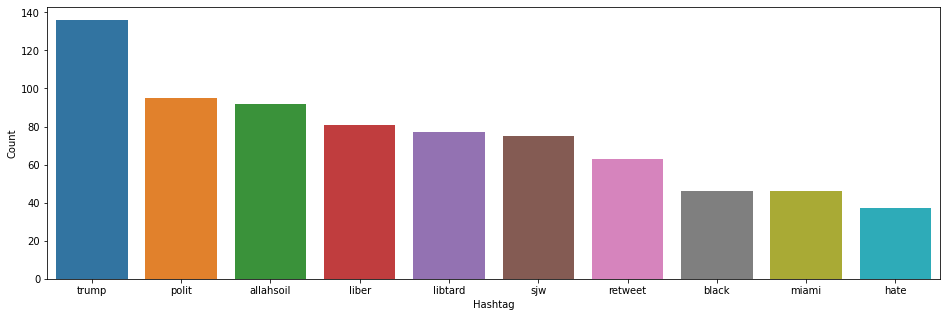

In [24]:
#hateful tweets
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
#selecting top 10 frequent hastags
e = e.nlargest(columns='Count', n=10)
plt.figure(figsize=(16, 5))
ax = sns.barplot(data=e, x= 'Hashtag', y= 'Count')
ax.set(ylabel = 'Count')
plt.show()

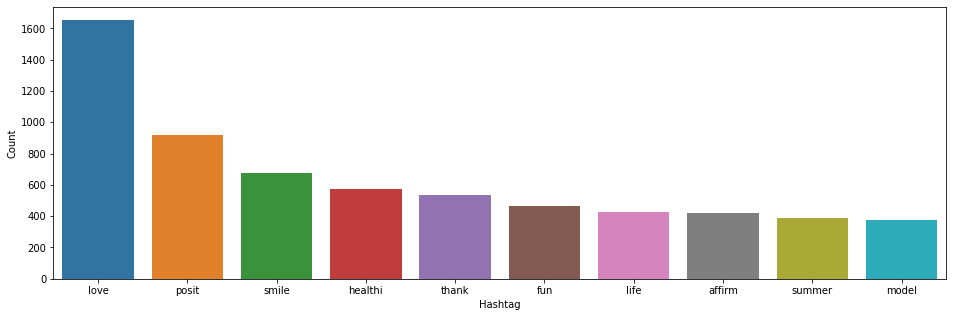

In [25]:
#non-hateful tweets
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

#selecting top 10 frequent hashtags
d = d.nlargest(columns = 'Count', n = 10)
plt.figure(figsize=(16, 5))
ax = sns.barplot(data=d, x= 'Hashtag', y = 'Count')
ax.set(ylabel = 'Count')
plt.show()

# **Data Processing Part-2**

In [27]:
#CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df = 0.90, min_df = 2, max_features = 1000, stop_words = 'english')

#bag of words feature matrix
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow

<49159x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 208642 stored elements in Compressed Sparse Row format>

In [28]:
#TF-IDF Features
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df = 0.90, min_df = 2, max_features = 1000, stop_words = 'english')

#TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])
tfidf

<49159x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 208642 stored elements in Compressed Sparse Row format>

# **Building Model**

Model using Bag-Of-Words features(CountVectorizer)

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:31962:]
test_bow = bow[31962:, :]

#data splitting
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=6, test_size = 0.3)

#training the model
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain)

prediction = lreg.predict_proba(xvalid_bow) #prediction on test data
prediction_int = prediction[:, 1] >= 0.3 #if prediction greater or equal to 0.3
prediction_int = prediction_int.astype(np.int)

#model accuracy score
f1_score(yvalid, prediction_int)

0.5716680637049456

In [41]:
#model using TF-IDF features

train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)
prediction = lreg.predict_proba(xvalid_tfidf) #prediction on test data
prediction_int = prediction[:, 1] >= 0.3 #if prediction greater or equal to 0.3
prediction_int = prediction_int.astype(np.int)

#model accuracy score
f1_score(yvalid, prediction_int)

0.5635864592863677